1.

In [1]:
import pandas as pd
#import the csv files
weather = pd.read_csv("seattle-weather.csv")

weather["date"] = pd.to_datetime(weather["date"])

#convert weather field into numerical values
weather_mapping = {'drizzle': 0, 'rain': 1, 'sun': 2, 'snow': 3, 'fog': 4}
weather["weather"] = weather["weather"].map(weather_mapping)

weather.dropna()
weather.drop(columns=["date"])

,precipitation,temp_max,temp_min,wind,weather
0,0.0,12.8,5.0,4.7,0
1,10.9,10.6,2.8,4.5,1
2,0.8,11.7,7.2,2.3,1
3,20.3,12.2,5.6,4.7,1
4,1.3,8.9,2.8,6.1,1
...,...,...,...,...,...
1456,8.6,4.4,1.7,2.9,1
1457,1.5,5.0,1.7,1.3,1
1458,0.0,7.2,0.6,2.6,4
1459,0.0,5.6,-1.0,3.4,2


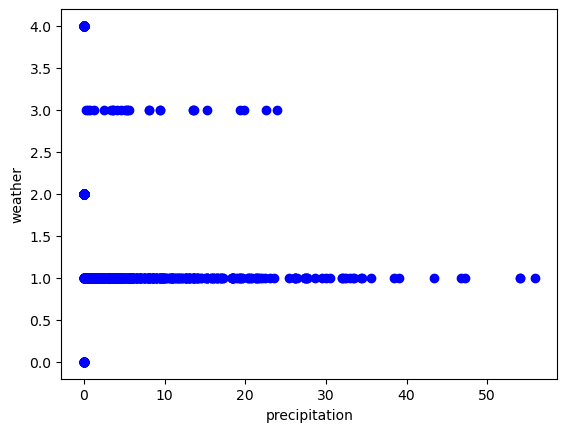

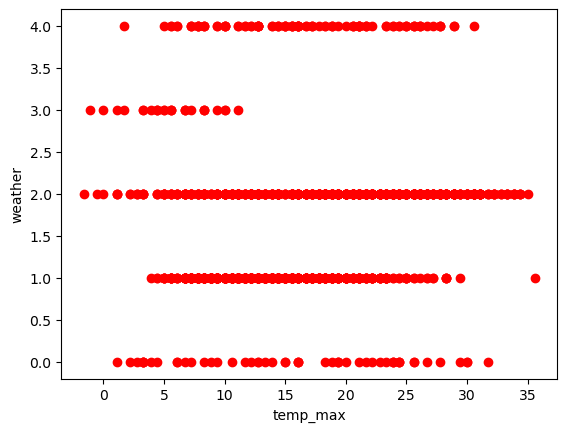

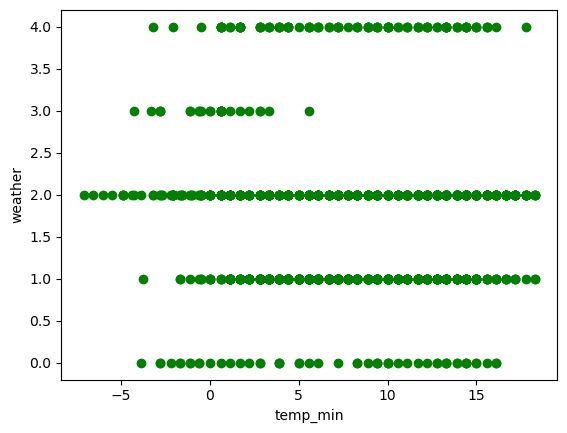

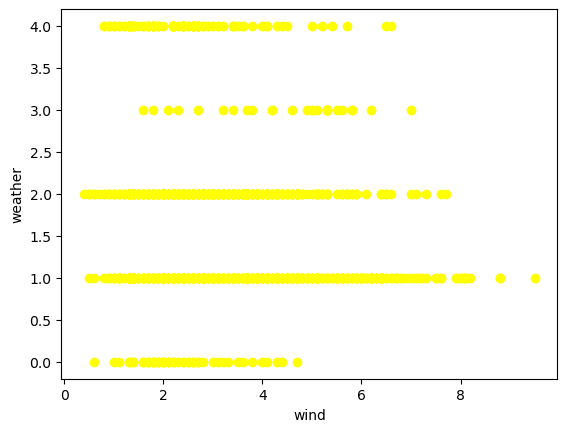

In [2]:
import matplotlib.pyplot as plt

plt.scatter(weather["precipitation"], weather["weather"], color="blue")
plt.xlabel("precipitation")
plt.ylabel("weather")
plt.show()

plt.scatter(weather["temp_max"], weather["weather"], color="red")
plt.xlabel("temp_max")
plt.ylabel("weather")
plt.show()

plt.scatter(weather["temp_min"], weather["weather"], color="green")
plt.xlabel("temp_min")
plt.ylabel("weather")
plt.show()

plt.scatter(weather["wind"], weather["weather"], color="yellow")
plt.xlabel("wind")
plt.ylabel("weather")
plt.show()



The goal is to use precipitation, temp_max, and wind to predict the overall weather condition that day. I chose these three features because they showed the biggest correlation in the initial exploration.

In [3]:
from sklearn.tree import DecisionTreeClassifier
X = weather[["temp_max","precipitation","wind"]]
Y = weather["weather"]

tree_classifier = DecisionTreeClassifier()
tree_classifier.fit(X,Y)

DecisionTreeClassifier()

In [4]:
from sklearn.metrics import confusion_matrix
y_predicted = tree_classifier.predict(X)
matrix = confusion_matrix(Y, y_predicted)
print(matrix)


[[ 50   0   3   0   0]
 [  3 633   5   0   0]
 [ 12   7 620   0   1]
 [  0   0   0  26   0]
 [  0   2  22   0  77]]


{'drizzle': 0, 'rain': 1, 'sun': 2, 'snow': 3, 'fog': 4}
the model is performing very well. It seems to have a bit of trouble differentiating sun from fog. maybe if i added in temp_min it would be able to defferentiat between the two

In [5]:
from sklearn.tree import DecisionTreeClassifier
X2 = weather[["temp_max","temp_min","precipitation","wind"]]
Y2 = weather["weather"]

tree_classifier2 = DecisionTreeClassifier()
tree_classifier2.fit(X2,Y2)

from sklearn.metrics import confusion_matrix
y_predicted2 = tree_classifier2.predict(X2)
matrix2 = confusion_matrix(Y2, y_predicted2)
print(matrix)


[[ 50   0   3   0   0]
 [  3 633   5   0   0]
 [ 12   7 620   0   1]
 [  0   0   0  26   0]
 [  0   2  22   0  77]]


running it again with temp_min helped out quite a bit. However looking at the chart now i am worryed about it overfiting 

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print ("Accuracy is ", accuracy_score(Y, y_predicted))
print ("Precision is ", precision_score(Y, y_predicted, average="weighted"))
print ("Sensitivity is ", recall_score(Y, y_predicted, average="weighted"))
print ("F1 is ", f1_score(Y, y_predicted, average="weighted"))

print()

print ("Accuracy is ", accuracy_score(Y2, y_predicted2))
print ("Precision is ", precision_score(Y2, y_predicted2, average="weighted"))
print ("Sensitivity is ", recall_score(Y2, y_predicted2, average="weighted"))
print ("F1 is ", f1_score(Y, y_predicted, average="weighted"))


Accuracy is  0.9623545516769336
Precision is  0.9643736592248366
Sensitivity is  0.9623545516769336
F1 is  0.9620188449917398

Accuracy is  0.9972621492128679
Precision is  0.9973710809996491
Sensitivity is  0.9972621492128679
F1 is  0.9620188449917398


In [7]:
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

validation_accuracy = []
validation_f1 =[]
fold_and_validate = KFold(n_splits=5, shuffle=True, random_state=145)
for train_set_indices, validation_set_indices in fold_and_validate.split(X):
    cv_train_set = X.iloc[train_set_indices]
    cv_train_target = Y.iloc[train_set_indices]
    #print(cv_train_set)
    
    cv_decision_tree = DecisionTreeClassifier()
    cv_decision_tree.fit(cv_train_set, cv_train_target)
    
    cv_xvalidation = X.iloc[validation_set_indices]
    cv_y_true = Y.iloc[validation_set_indices]
    cv_y_predicted = cv_decision_tree.predict(cv_xvalidation)
    
    cv_accuracy_score = accuracy_score(cv_y_true, cv_y_predicted)
    cv_f1_score = f1_score(cv_y_true, cv_y_predicted,  average="weighted")

    validation_accuracy.append(cv_accuracy_score)
    validation_f1.append(cv_f1_score)

print("without min_temp")
print("Cross validation accuracies are: ", validation_accuracy)
print("Cross validation f1 scores  are: ", validation_f1)

validation_accuracy = []
validation_f1 =[]
for train_set_indices, validation_set_indices in fold_and_validate.split(X2):
    cv_train_set = X2.iloc[train_set_indices]
    cv_train_target = Y2.iloc[train_set_indices]
    #print(cv_train_set)
    
    cv_decision_tree = DecisionTreeClassifier()
    cv_decision_tree.fit(cv_train_set, cv_train_target)
    
    cv_xvalidation = X2.iloc[validation_set_indices]
    cv_y_true = Y2.iloc[validation_set_indices]
    cv_y_predicted = cv_decision_tree.predict(cv_xvalidation)
    
    cv_accuracy_score = accuracy_score(cv_y_true, cv_y_predicted)
    cv_f1_score = f1_score(cv_y_true, cv_y_predicted,  average="weighted")

    validation_accuracy.append(cv_accuracy_score)
    validation_f1.append(cv_f1_score)
print()
print("with min_temp")
print("Cross validation accuracies are: ", validation_accuracy)
print("Cross validation f1 scores  are: ", validation_f1)

without min_temp
Cross validation accuracies are:  [0.7372013651877133, 0.7636986301369864, 0.7465753424657534, 0.7431506849315068, 0.7773972602739726]
Cross validation f1 scores  are:  [0.7475609202362985, 0.765547891400962, 0.7438388787937115, 0.7314185685082558, 0.7883443902201362]

with min_temp
Cross validation accuracies are:  [0.7372013651877133, 0.7602739726027398, 0.8047945205479452, 0.7191780821917808, 0.7671232876712328]
Cross validation f1 scores  are:  [0.7501618909009873, 0.7804120781761129, 0.8014803852022696, 0.7242425880861477, 0.7784416699260039]


Both models performed notably worse on the cross-validation than they did initially. perhaps both models were overfitting. temp_min did not seem to improve the cross-validation scores so I will continue without it. 

In [8]:
from sklearn.svm import SVC
X = weather[["temp_max","precipitation","wind"]]
Y = weather["weather"]

svm_classifier = SVC(kernel="linear")
svm_classifier.fit(X,Y)

SVC(kernel='linear')

In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_predicted = svm_classifier.predict(X)
matrix = confusion_matrix(Y, y_predicted)
print(matrix)

print ("Accuracy is ", accuracy_score(Y, y_predicted))
print ("Precision is ", precision_score(Y, y_predicted, average="weighted"))
print ("Sensitivity is ", recall_score(Y, y_predicted, average="weighted"))
print ("F1 is ", f1_score(Y, y_predicted, average="weighted"))


[[  0   0  53   0   0]
 [  0 597  44   0   0]
 [  0   0 640   0   0]
 [  0  21   0   5   0]
 [  0   0 101   0   0]]
Accuracy is  0.8501026694045175
Precision is  0.7761815625127028
Sensitivity is  0.8501026694045175
F1 is  0.8012018401849624


C:\Users\s553982\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
from sklearn.model_selection import KFold

validation_accuracy = []
validation_f1 =[]
fold_and_validate = KFold(n_splits=5, shuffle=True, random_state=145)
for train_set_indices, validation_set_indices in fold_and_validate.split(X):
    cv_train_set = X.iloc[train_set_indices]
    cv_train_target = Y.iloc[train_set_indices]
    #print(cv_train_set)
    
    svm_classifier = SVC()
    svm_classifier.fit(cv_train_set, cv_train_target)
    
    cv_xvalidation = X.iloc[validation_set_indices]
    cv_y_true = Y.iloc[validation_set_indices]
    cv_y_predicted = svm_classifier.predict(cv_xvalidation)
    
    cv_accuracy_score = accuracy_score(cv_y_true, cv_y_predicted)
    cv_f1_score = f1_score(cv_y_true, cv_y_predicted,  average="weighted")

    validation_accuracy.append(cv_accuracy_score)
    validation_f1.append(cv_f1_score)


print("Cross validation accuracies are: ", validation_accuracy)
print("Cross validation f1 scores  are: ", validation_f1)

Cross validation accuracies are:  [0.7713310580204779, 0.791095890410959, 0.7397260273972602, 0.7465753424657534, 0.7671232876712328]
Cross validation f1 scores  are:  [0.7299841029305189, 0.7532479597784902, 0.6916710989775309, 0.6854126495960453, 0.7195208618983089]


The model is worse than the decision tree. RBF and Leniear performed much better than Sigmoid on this data set. These models have an issue with categorizing all of the drizzle and fog conditions as something else and not actually predicting their occurrence. 

What I learned:
The decision tree appears to be better for datasets with a low number of specific attributes than the svm. While the accuracy was higher that the svms, the svm models would often ignore certain categories. 